# Drivers of Enrollment on Coursera
## Coursera analysis 

## 1. Introduction

This analysis explores key factors influencing online course success, focusing specifically on student enrollments as a primary indicator of engagement and popularity. We examine course ratings, difficulty levels, and organizational presence to understand what drives student interest and course selection. By identifying high-performing course categories and popular providers, we can uncover trends in online learning and gain insights into learner preferences.

Key questions addressed in this study:

Which course types generate the highest enrollments?
Which organizations dominate the online learning space in terms of enrollment?
Do higher ratings correlate with higher enrollments?
Which certificate types attract the most learners?

Through data-driven insights, this analysis aims to help education providers, e-learning businesses, and researchers understand the dynamics of student engagement in online learning and identify factors that contribute to course popularity on the Coursera platform.

Analysis structure :

1. Introduction
2. Data cleaning
3. Dealing with the outliers
4. Enrollment and General Overview of the Dataset
5. Analysis on ratings and enrollment 
6. Analysis on course difficulty and enrollment
7. Analysis on certificate type and enrollment
8. Most  popular courses and institutions by enrollment and their categorization
9. Least  popular courses and institutions by enrollment and their categorization
10. Deeper Analysis and Graphs on Enrollment Factors
11. Analysis conclusion
12. Suggestions for analysis improvements

Importing the libraries, custom functions and main source of data as df :

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from CourseraCustomFunctions import (
    convert_enrollment,
    detect_outliers_iqr,
)
from CourseraGenericGraphFunctions import (
    plot_histogram,
    plot_scatter_with_top3_outliers_annotated,
    plot_bar_chart,
    plot_horizontal_bar_chart_top10,
    plot_certificate_enrollment,
    plot_avg_max,
    plot_scatter_difficulty_enrollment,
    plot_scatter_certificate_difficulty_type,
)

Reading Coursera csv file and declaring main source of data as df :

In [152]:
df = pd.read_csv("coursea_data.csv")

## 2. Data Cleaning

Data cleaning is an essential step in any data analysis process. It ensures that the dataset is accurate, consistent, and ready for meaningful insights. I plan to verify that the data has been imported correctly, check for missing values, identify and remove duplicates, eliminate unnecessary information, and address any outliers. These steps will ensure the dataset is well-prepared and clean for analysis.

Checking if data is imported correctly : 

In [153]:
df.head()

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


Let's drop Unnamed column, since it doesn't provide much information :

In [154]:
df.drop(columns=["Unnamed: 0"], inplace=True)

Column names should be lowercase and consistent :

In [155]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

Course difficulty levels like "Mixed", "Intermediate", etc., should be standardized as well :

In [156]:
df["course_difficulty"] = df["course_difficulty"].str.strip().str.lower()

Checking for empty values (there was none) :

In [157]:
df.isnull().values.any()

np.False_

In [158]:
print(df.columns)

Index(['course_title', 'course_organization', 'course_certificate_type',
       'course_rating', 'course_difficulty', 'course_students_enrolled'],
      dtype='object')


Let's check if there's any duplicate values :

In [159]:
num_duplicates = df.duplicated().sum()

print(num_duplicates)

0


 I will check if there's courses with the same name and from same institutions :

In [160]:
duplicate_courses = df[
    df.duplicated(subset=["course_title", "course_organization"], keep=False)
]

duplicate_courses_comparison = (
    duplicate_courses.groupby(["course_title", "course_organization"])
    .agg(
        {
            "course_certificate_type": lambda x: list(set(x)),
            "course_rating": lambda x: list(set(x)),
            "course_difficulty": lambda x: list(set(x)),
            "course_students_enrolled": lambda x: list(set(x)),  #
        }
    )
    .reset_index()
)

print(duplicate_courses_comparison)

                   course_title       course_organization  \
0  Developing Your Musicianship  Berklee College of Music   

    course_certificate_type course_rating  course_difficulty  \
0  [COURSE, SPECIALIZATION]         [4.8]  [mixed, beginner]   

  course_students_enrolled  
0               [41k, 54k]  


Even though there's 2 courses with same name and it's from same institution, their certificate type and difficulty doesn't match, so it can't be considered total duplicates. As well their number of enrolled students differs.  I will leave them both in the analysis.

Since values contain "k" (thousands) and "m" (millions), we need to clean and convert them to integers before proceeding. I will use my custom function 'convert_enrollment' I created in a separate file :

In [161]:
df["course_students_enrolled"] = df["course_students_enrolled"].apply(
    convert_enrollment
)

Let's verify conversion : 

In [162]:
print(df["course_students_enrolled"].dtype)
print(df["course_students_enrolled"].head())

float64
0      5300.0
1     17000.0
2    130000.0
3     91000.0
4    320000.0
Name: course_students_enrolled, dtype: float64


## 3. Dealing with the outliers

Let's check general information with describe function :

In [163]:
df.describe()

,course_rating,course_students_enrolled
count,891.000000,8.910000e+02
mean,4.677329,9.055208e+04
std,0.162225,1.819365e+05
min,3.300000,1.500000e+03
25%,4.600000,1.750000e+04
50%,4.700000,4.200000e+04
75%,4.800000,9.950000e+04
max,5.000000,3.200000e+06


I will use another custom function to detect an outliers :

In [164]:
outlier_counts = detect_outliers_iqr(df)

print("Outlier Counts per Column:")
print(outlier_counts)

Outlier Counts per Column:
course_rating               17
course_students_enrolled    78
dtype: int64


I will take a deeper look into possible ratings outliers. Let's check extremely which low and high ratings and if they could be considered outliers :

In [165]:
df[df["course_rating"] < 2.5]

df[df["course_rating"] == 5.0]

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled
251,El Abogado del Futuro: Legaltech y la Transfor...,Universidad Austral,COURSE,5.0,beginner,1500.0
432,Infectious Disease Modelling,Imperial College London,SPECIALIZATION,5.0,intermediate,1600.0


There's no valid reason perfect ratings are outliers (even if the courses are small). Also I dont have more of type and count of ratings, so I will keep them in the analysis.

I will check enrollment outliers, using scatter plot custom function : 

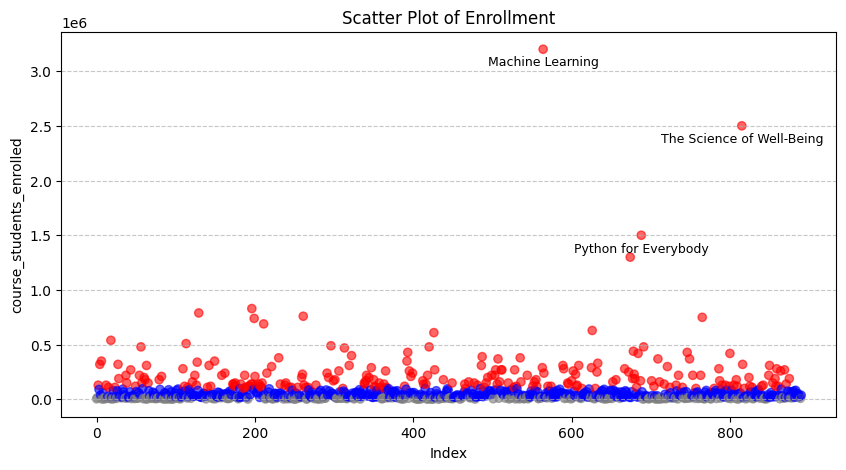

In [166]:
plot_scatter_with_top3_outliers_annotated(df, column="course_students_enrolled")

There are some extreme outliers in the number of students enrolled in each course. However, these are not errors but legitimate data points that reflect real enrollment trends. Keeping these outliers will ensure a more accurate and precise analysis, as they highlight the natural distribution of course popularity.

I decided neither delete the enrollments outliers, neither keep them, but to log them, because :
1. Log transformation normalizes the data, making it easier to analyze.
2. Now smaller courses are more visible, instead of being overshadowed by large ones.
3. I can better compare course enrollments, rather than focusing only on massive courses.

In [167]:
df["log_students"] = np.log1p(df["course_students_enrolled"])

df[["course_students_enrolled", "log_students"]].head()

,course_students_enrolled,log_students
0,5300.0,8.575651
1,17000.0,9.741027
2,130000.0,11.775297
3,91000.0,11.418626
4,320000.0,12.676079


## 4. Enrollment and General Overview of the Dataset :

Let's count total number of observations, unique organizations, certificate and difficulty types :

In [168]:
num_courses = df.shape[0]
num_unique_organizations = df["course_organization"].nunique()
num_certificate_types = df["course_certificate_type"].nunique()
num_difficulty_levels = df["course_difficulty"].nunique()

dataset_summary = {
    "Total Courses": num_courses,
    "Unique Organizations": num_unique_organizations,
    "Unique Certificate Types": num_certificate_types,
    "Unique Difficulty Levels": num_difficulty_levels,
}

summary_df = pd.DataFrame(dataset_summary.items(), columns=["Metric", "Value"])

print(summary_df)

                     Metric  Value
0             Total Courses    891
1      Unique Organizations    154
2  Unique Certificate Types      3
3  Unique Difficulty Levels      4


General overview of the dataset :

1. Number of Courses: 891
• The dataset includes a substantial variety of courses, covering different topics and difficulty levels.
• With almost 900 courses, it provides a broad view of online education trends.

2. Unique Organizations: 154
• Courses are offered by 154 different institutions, suggesting a diverse mix of universities and companies.
• Some organizations likely offer far more courses than others.

3. Certificate Types: 3
• There are only 3 types of certificates, meaning the platform might have a consistent certification structure.
• The most common certificate types is Courses, Specializations, and Professional Certificates.

4. Difficulty Levels: 4
• The platform categorizes courses into 4 difficulty levels—likely Beginner, Intermediate, Advanced, and Mixed.
• If one difficulty level has significantly more courses, it might indicate where most demand is.

Calculations on mean, median, minimum and maximum values of the students enrolled :

In [169]:
enrollment_stats = {
    "Mean Students Enrolled": df["course_students_enrolled"].mean(),
    "Median Students Enrolled": df["course_students_enrolled"].median(),
    "Min Students Enrolled": df["course_students_enrolled"].min(),
    "Max Students Enrolled": df["course_students_enrolled"].max(),
}

enrollment_df = pd.DataFrame(enrollment_stats.items(), columns=["Metric", "Value"])

print("\nStudent Enrollment Statistics")
print(enrollment_df)


Student Enrollment Statistics
                     Metric         Value
0    Mean Students Enrolled  9.055208e+04
1  Median Students Enrolled  4.200000e+04
2     Min Students Enrolled  1.500000e+03
3     Max Students Enrolled  3.200000e+06


Course enrollment summary :
1. Mean (90,552) is much larger than the Median (42,000), which means a few massively popular courses are pulling the average up.
2. The highest-enrolled course has 3.2M students, which means a huge contrast compared to the smallest (1,500 students).
3. This suggests a "power law" distribution ans that few courses are super popular, while many have far fewer enrollments.

From the previous scatter plot we can tell that 3 most popular courses by far are (in order) :
1. Machine Learning (Stanford University): 3,200,000 students
2. The Science of Well-Being (Yale University): 2,500,000 students
3. Python for Everybody (University of Michigan): 1,500,000 students

From the graph below, you can see the huge difference between the most popular course and just the average course :

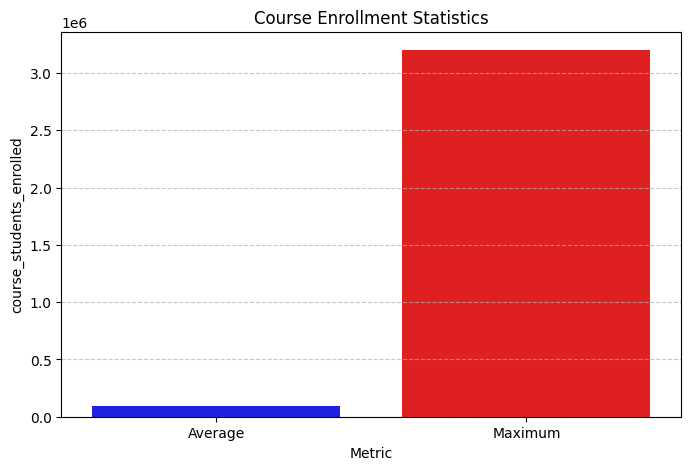

In [170]:
plot_avg_max(df, "course_students_enrolled", title="Course Enrollment Statistics")

## 5. Analysis on ratings and enrollment

Let's investigate such disparity of the enrollment. Maybe it has something to do with high ratings?

In [171]:
ratings_stats = {
    "Mean Course Rating": df["course_rating"].mean(),
    "Median Course Rating": df["course_rating"].median(),
}

ratings_df = pd.DataFrame(ratings_stats.items(), columns=["Metric", "Value"])

print("0Course Ratings Statistics")
print(ratings_df)

0Course Ratings Statistics
                 Metric     Value
0    Mean Course Rating  4.677329
1  Median Course Rating  4.700000


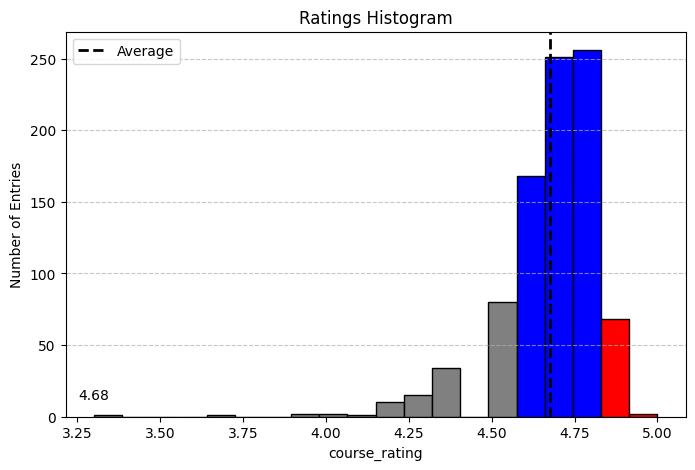

In [172]:
plot_histogram(df, column="course_rating")

Course ratings :

1. Ratings are generally very high and the majority of courses are well-rated.
2. Mean (4.677) is slightly lower than the median (4.7), meaning there are some low-rated courses dragging the average down, but not significantly.
3. Most courses likely fall between 4.5 - 5.0 ratings, a right-skewed distribution where bad ratings are rare.

Exploring corellation of popularity and ratings :

In [173]:
correlation = df["course_students_enrolled"].corr(df["course_rating"])

correlation_summary = pd.DataFrame(
    {
        "Metric": ["Correlation between Students Enrolled and Course Ratings"],
        "Value": [correlation],
    }
)

print("\nCorrelation between Students Enrolled and Course Ratings")
print(correlation_summary)


Correlation between Students Enrolled and Course Ratings
                                              Metric    Value
0  Correlation between Students Enrolled and Cour...  0.07109


The correlation coefficient of approximately 0.07109 suggests that there is a very weak positive correlation between the number of students enrolled in courses and the course ratings. In other words, as the number of students enrolled in a course increases, the course rating tends to increase slightly, but the relationship is not strong.

I will confirm this conclusion comparing most popular courses versus least popular courses and their average rating :

In [174]:
top_popular_courses = df.nlargest(10, "course_students_enrolled")[
    ["course_title", "course_students_enrolled", "course_rating"]
]
least_popular_courses = df.nsmallest(10, "course_students_enrolled")[
    ["course_title", "course_students_enrolled", "course_rating"]
]

mean_rating_popular = top_popular_courses["course_rating"].mean()
mean_rating_unpopular = least_popular_courses["course_rating"].mean()

rating_comparison = pd.DataFrame(
    {
        "Category": ["Most Popular Courses", "Least Popular Courses"],
        "Average Rating": [mean_rating_popular, mean_rating_unpopular],
    }
)

print("\n Comparison of Ratings: Popular vs. Unpopular Courses")
print(rating_comparison)


 Comparison of Ratings: Popular vs. Unpopular Courses
                Category  Average Rating
0   Most Popular Courses            4.73
1  Least Popular Courses            4.72


Does the reviews affect course popularity?

1. The difference in ratings is very small (4.73 vs. 4.72).
2. This suggests that popularity does not strongly correlate with higher ratings.
3. Both popular and unpopular courses have high average ratings (above 4.7).

This might be because course ratings are already high overall (most ratings seem clustered around 4.5+) or this could mean that ratings on the platform tend to be inflated, or users mainly rate courses they like.

## 6. Analysis on course difficulty and enrollment

If it's not good ratings that makes the course popular, maybe it's the course difficulty that matters? Let's compare course difficulty level and enrollment rate :

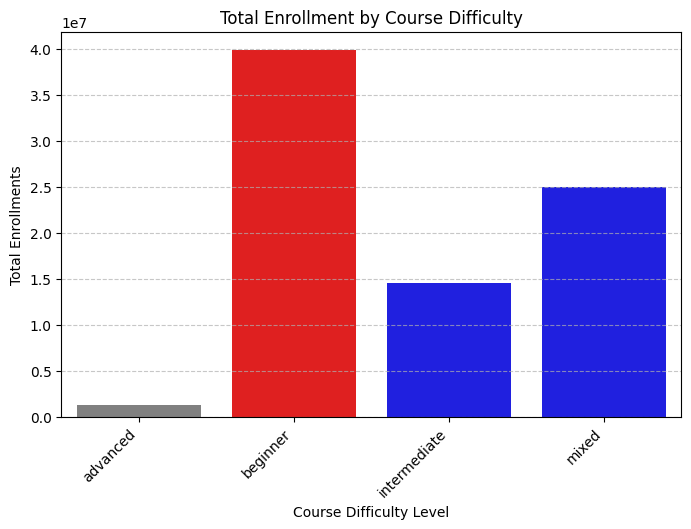

In [175]:
enrollment_by_difficulty = df.groupby("course_difficulty", as_index=False)[
    "course_students_enrolled"
].sum()

plot_bar_chart(
    df=enrollment_by_difficulty,
    category_column="course_difficulty",
    value_column="course_students_enrolled",
    title="Total Enrollment by Course Difficulty",
    xlabel="Course Difficulty Level",
    ylabel="Total Enrollments",
    highlight_max=True,
)

In [176]:
avg_enrollments_per_difficulty = (
    df.groupby("course_difficulty")["course_students_enrolled"].mean().reset_index()
)

print(avg_enrollments_per_difficulty)

  course_difficulty  course_students_enrolled
0          advanced              66547.368421
1          beginner              81974.948665
2      intermediate              73264.141414
3             mixed             133633.155080


Why is "Mixed" higher in mean() than sum()?

"Mixed" may have fewer courses but with higher enrollments per course, increasing the average.
In contrast, "Beginner" may have many courses, causing a higher total enrollment but lower average per course.

Beginner courses are the most popular because they have the highest total enrollment (~39.9M students), but Mixed courses has the highest average enrollment (~133.6K students per course).

## 7. Analysis on certificate type and enrollment

Now, let's check which certificate type attracts the most students. Firstly, I will group the data by certificate type and sum enrollments :

In [177]:
enrollments_by_type = df.groupby("course_certificate_type")[
    "course_students_enrolled"
].sum()

I will calculate the percentages :

In [178]:
percentages = (enrollments_by_type / enrollments_by_type.sum()) * 100

print("Percentages of Total Enrollments:")
print(percentages)

print("\nFormatted Percentages:")
for cert_type, percentage in percentages.items():
    print(f"{cert_type}: {percentage:.2f}%")

Percentages of Total Enrollments:
course_certificate_type
COURSE                      63.373941
PROFESSIONAL CERTIFICATE     2.836324
SPECIALIZATION              33.789735
Name: course_students_enrolled, dtype: float64

Formatted Percentages:
COURSE: 63.37%
PROFESSIONAL CERTIFICATE: 2.84%
SPECIALIZATION: 33.79%


Let's confirm our findings in a bar graph :

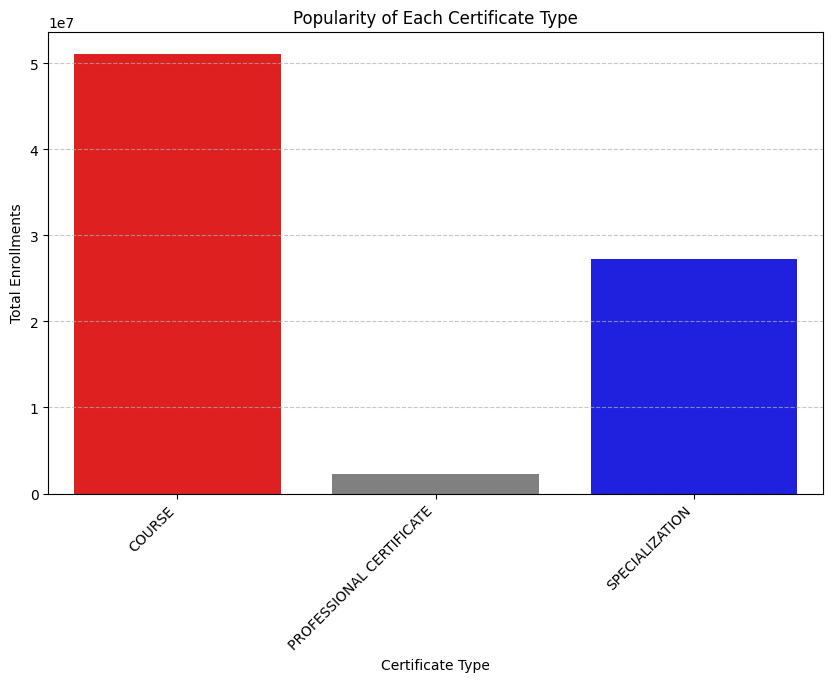

In [179]:
plot_certificate_enrollment(df)

Among students the most popular certificate type are Courses, followed by Specializations. There are very few courses orientated to professional certificate type. 

## 8. Most  popular courses and institutions by enrollment and their categorization

Let's find the top 10 organizations offering the most courses :

In [180]:
top_organizations = df["course_organization"].value_counts().head(10)

top_organizations_df = top_organizations.reset_index()
top_organizations_df.columns = ["Organization", "Number of Courses"]

print(top_organizations_df)

                                 Organization  Number of Courses
0                  University of Pennsylvania                 59
1                      University of Michigan                 41
2                                Google Cloud                 34
3                    Johns Hopkins University                 28
4                             Duke University                 28
5            University of California, Irvine                 27
6                                         IBM                 22
7  University of Illinois at Urbana-Champaign                 22
8             University of California, Davis                 21
9              University of Colorado Boulder                 19


The University of Pennsylvania leads with 59 courses, followed by the University of Michigan with 41.  

Let's group the top 10 least and most popular courses :

In [181]:
top_popular_courses = df.nlargest(10, "course_students_enrolled")[
    ["course_title", "course_students_enrolled"]
]

least_popular_courses = df.nsmallest(10, "course_students_enrolled")[
    ["course_title", "course_students_enrolled"]
]

course_popularity = df.groupby("course_title", as_index=False)[
    "course_students_enrolled"
].sum()

Visualization of top 10 most popular courses in a bar chart :

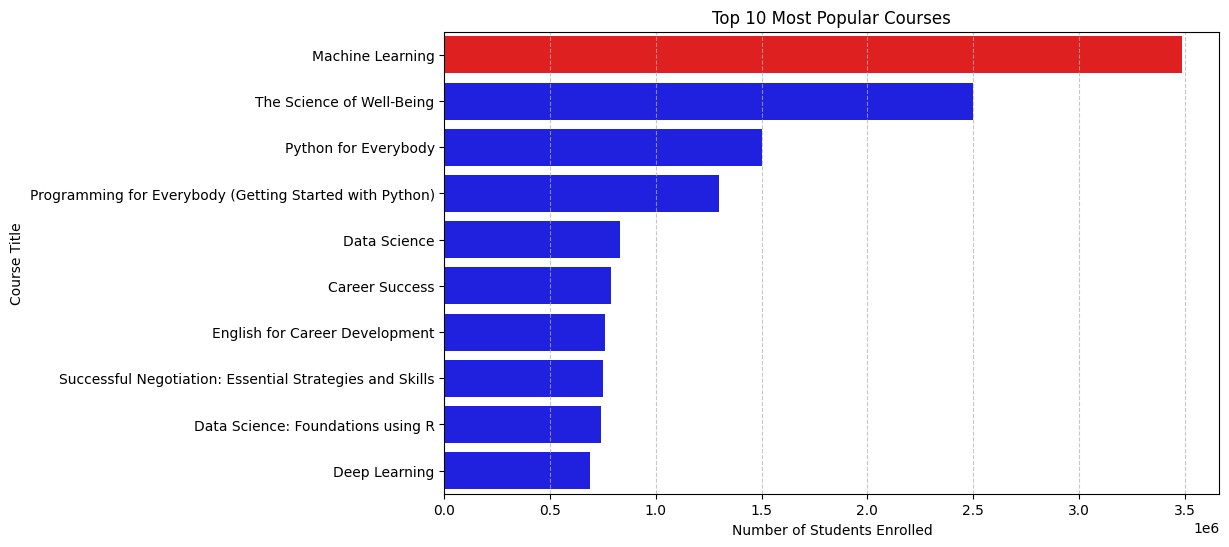

In [182]:
plot_horizontal_bar_chart_top10(
    course_popularity.nlargest(10, "course_students_enrolled"),
    "course_title",
    "course_students_enrolled",
    "Top 10 Most Popular Courses",
    "Number of Students Enrolled",
    "Course Title",
)

Course Type Categorization and Estimated Percentage Breakdown:

Foundational Computer Science/Programming:  These courses teach fundamental programming skills or introduce core computer science concepts.


•Python for Everybody

•Programming for Everybody (Getting Started with Python)

•Data Science: Foundations using R

Estimated Percentage: 30%


Advanced/Specialized Computer Science/AI:  These delve into more advanced topics like machine learning, deep learning, or specific data science skills.


•Machine Learning

•Deep Learning

•Data Science

Estimated Percentage: 30%


Personal/Professional Development: Courses focused on enhancing career skills, personal growth, or language proficiency.


•Career Success

•English for Career Development

•Successful Negotiation: Essential Strategies and Skills

Estimated Percentage: 30%


Health/Well-being: Courses related to mental or physical health, mindfulness, or well-being.


•The Science of Well-Being

Estimated Percentage: 10%

Data with a top courses is clear, now we need to categorize and take a deeper look into course institutions, lets break institutions into three groups:

1. Top Tier Universities: (Globally recognized, highly prestigious, often research-intensive)
2. Tier Below Universities: (Still reputable universities, but perhaps with a more regional or specialized focus, or not as consistently ranked as "Top Tier")
3. Prominent Institutions/Organizations: (Companies, specialized institutions, online platforms)

Visualization of Top 10 institutions with highest enrollment in a bar chart :

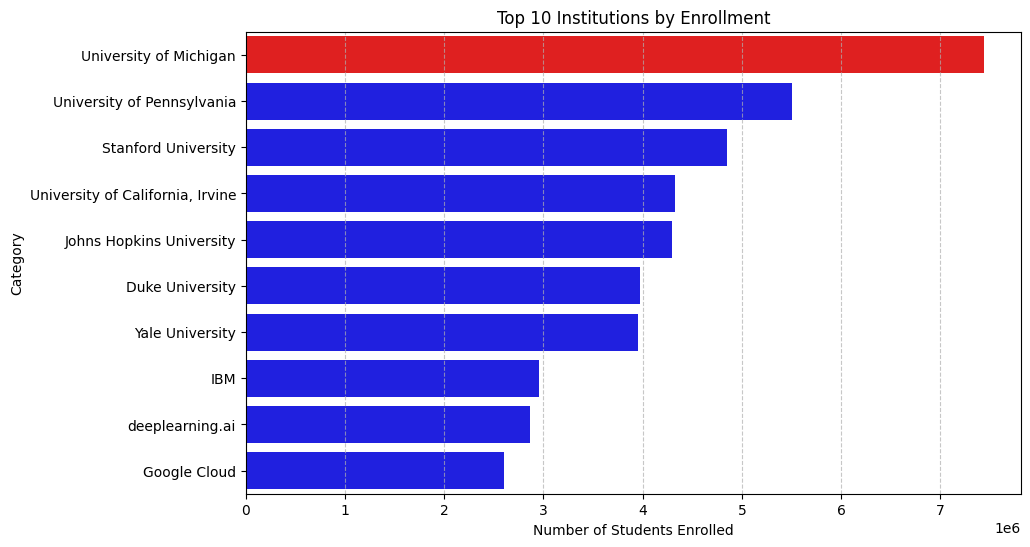

In [183]:
plot_horizontal_bar_chart_top10(
    df.groupby("course_organization", as_index=False)["course_students_enrolled"]
    .sum()
    .nlargest(10, "course_students_enrolled"),
    "course_organization",
    "course_students_enrolled",
    "Top 10 Institutions by Enrollment",
)

Top 10 Institutions by Enrollment:

Top Tier Universities:


•University of Michigan

•University of Pennsylvania

•Stanford University

•Duke University

•Yale University

•University of California, Irvine 

Percentage (Top 10): 60%


Tier Below Universities:


•Johns Hopkins University 

Percentage (Top 10): 10%

Prominent Institutions/Organizations:


•IBM

•deeplearning.ai

•Google Cloud

Percentage (Top 10): 30%

The highest enrollment course was Machine Learning (Standford University), The Science of Well Being(Yale University) and Python for Everybody(University of Michigan). An estimated 60% of the most popular courses focus on computer science (both foundational and advanced) and professional development. Health/well-being courses make up the remaining 10%.  Institutionally, top universities account for an estimated 60% of top course enrollments, with prominent organizations making up the remaining 30% and tier-below universities 10%. University of Michegan and University of Pennsylvania were top choices among students. 

## 9. Least  popular courses and institutions by enrollment and their categorization

Now let's have the same analysis with the worst perfoming courses and institutions (by enrollment). Top 10 Least popular courses bar chart :

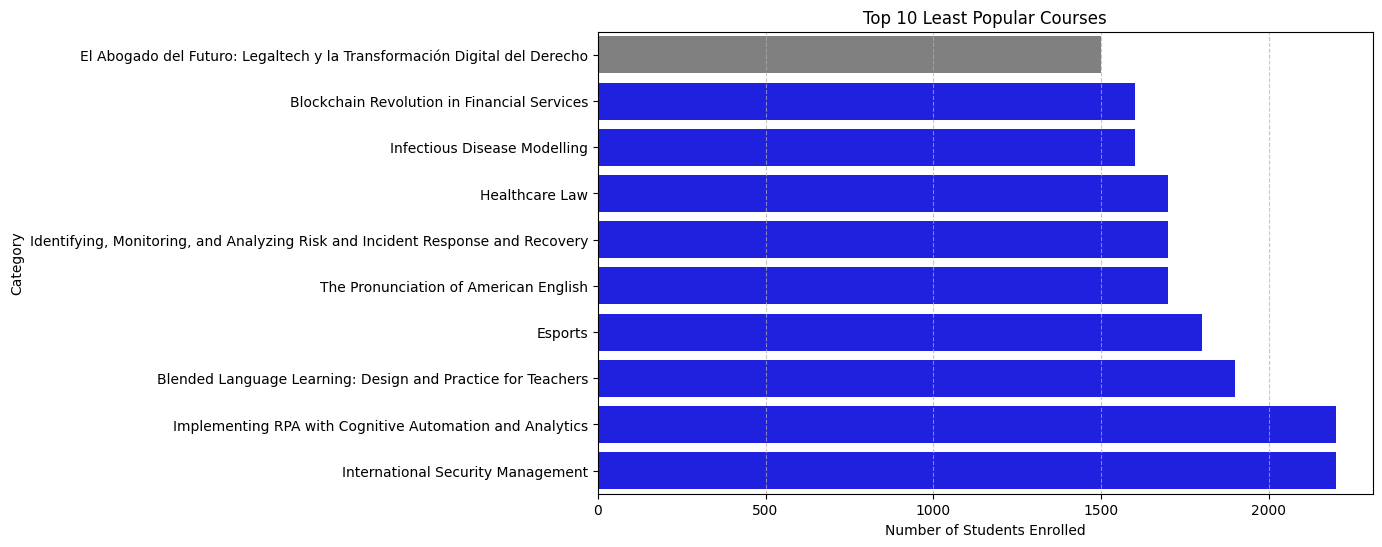

In [184]:
blue_gray_black = ("blue", "gray")

plot_horizontal_bar_chart_top10(
    df.nsmallest(10, "course_students_enrolled"),
    "course_title",
    "course_students_enrolled",
    "Top 10 Least Popular Courses",
)

Course Type Categorization and Estimated Percentage Breakdown:

Law/Legal Studies: Courses focused on legal topics, including technology's impact on law or specific areas of law.


• El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho

• Healthcare Law

Estimated Percentage: 20%


Finance/Business/Technology: Courses related to finance, business, or the intersection of technology and these fields.


• Blockchain Revolution in Financial Services

• Implementing RPA with Cognitive Automation and Analytics

Estimated Percentage: 20%


Health/Medicine: Courses focused on health-related topics, such as disease modeling.


• Infectious Disease Modelling


Estimated Percentage: 10%


Cybersecurity/Risk Management: Courses addressing cybersecurity, risk analysis, or incident response.


• Identifying, Monitoring, and Analyzing Risk and Incident Response and Recovery

Estimated Percentage: 10%


Language/Education: Courses focused on language learning, teaching methodologies, or educational practices.


• The Pronunciation of American English

• Blended Language Learning: Design and Practice for Teachers

Estimated Percentage: 20%


Other/Miscellaneous: Courses that don't fit neatly into the above categories.


• Esports

• International Security Management

Estimated Percentage: 20%

Visualization of Top 10 institutions with lowest enrollment :

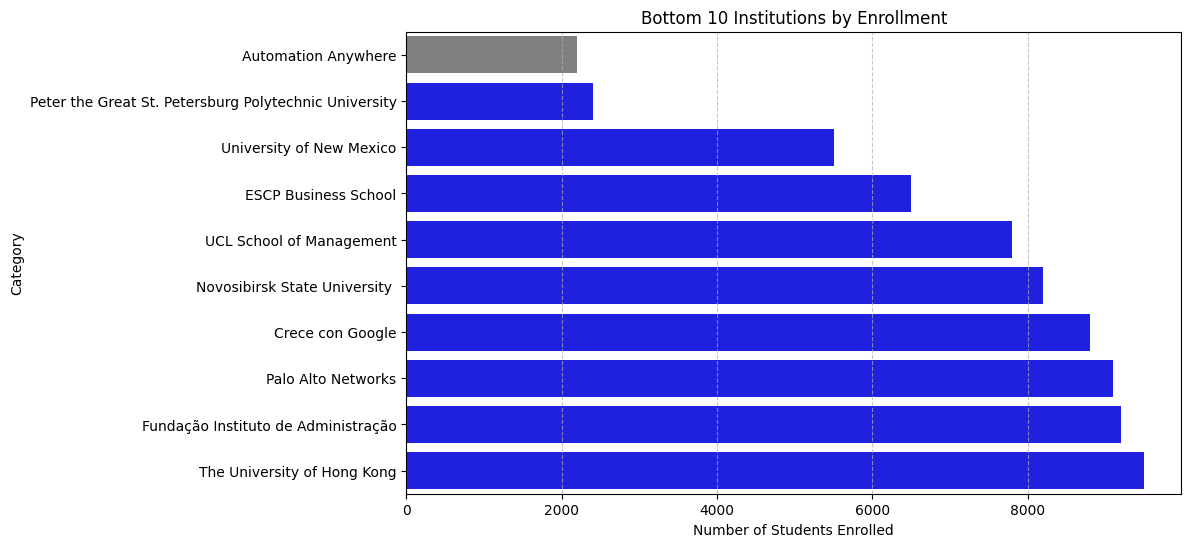

In [185]:
plot_horizontal_bar_chart_top10(
    df.groupby("course_organization", as_index=False)["course_students_enrolled"]
    .sum()
    .nsmallest(10, "course_students_enrolled"),
    "course_organization",
    "course_students_enrolled",
    "Bottom 10 Institutions by Enrollment",
)

Bottom 10 Institutions by Enrollment:

Top Tier Universities:

None
Percentage (Bottom 10): 0%

Tier Below Universities:

•Peter the Great St. Petersburg Polytechnic University

•University of New Mexico

•Novosibirsk State University

•The University of Hong Kong

Percentage (Bottom 10): 40%

Prominent Institutions/Organizations:

•ESCP Business School

•UCL School of Management

•Fundação Instituto de Administração

•Automation Anywhere

•Crece con Google

•Palo Alto Networks

Percentage (Bottom 10): 60%

The least popular courses showcase a broader spread: an estimated 20% each in law/legal studies, finance/business/technology, and language/education, along with 10% each in health/medicine, cybersecurity, and other/miscellaneous topics.  This highlights a long tail of niche interests in online learning, even as technical and professional skills dominate top enrollment. Bottom enrollment shifts, with tier-below universities comprising an estimated 40% and prominent organizations 60%, showing a wider institutional reach for niche topics. Course correlation between ratings and enrollments were insignificant.

## 10. Deeper Analysis and Graphs on Enrollment Factors

I want to take a deeper look on how impactful is student enrollment. I will bring back scatter plot of enrollment, but replace it's bubbles with different icons to give me a better view of the situation.

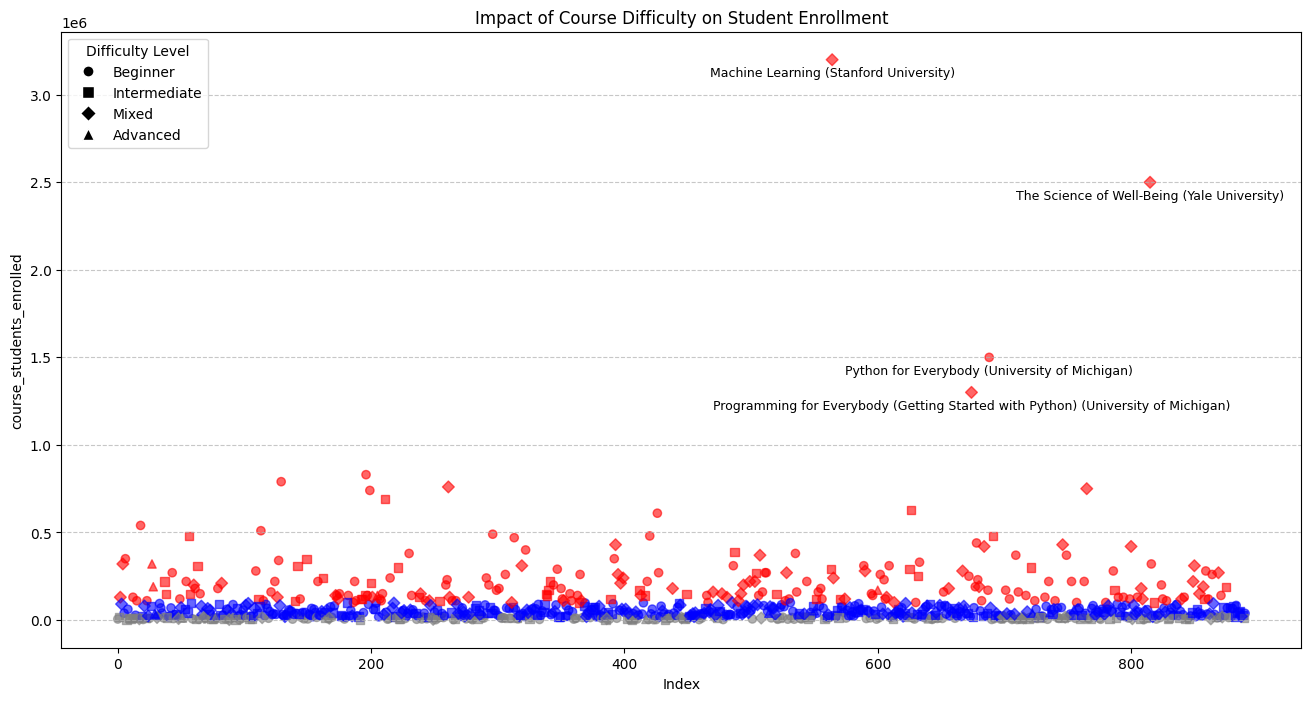

In [186]:
plot_scatter_difficulty_enrollment(df, "course_students_enrolled", figsize=(16, 8))

Seems that Mixed difficulty are heavily impacted by three courses from Top Universities that are way ahead of others in terms of Enrollment, while Begginer difficulty has one clear leader (Python for Everybody), but way more courses with various popularity of Enrollment. No surprises that it's hard to spot Advanced and Intermediate courses since they leading courses and are less popular in quantity as well.

Let's take step further and color the icons not with the Enrollment rate frequence, but rather with the specific colors represinting their Certificate Type. This way we will see the main factors of student enrollment in the same graph :

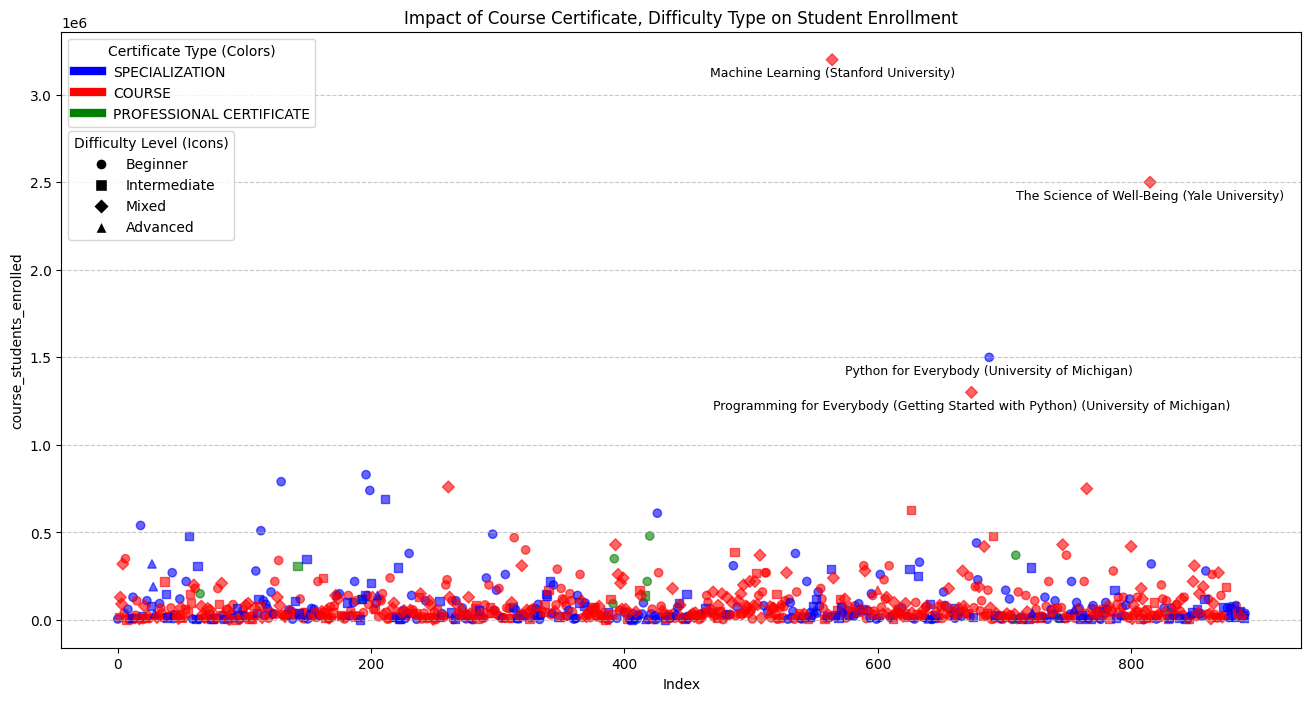

In [187]:
plot_scatter_certificate_difficulty_type(
    df, "course_students_enrolled", figsize=(16, 8)
)

Again, Python for Everybody course stands out as Specialization Certificate leader, but all the other top courses are in red, meaning, the Course Certificate domination. Machine Learning, The Science of Well-Being and Programming for Everybody are all Mixed difficulty courses from Top Universities institution awarding their students with the Course Certificates, which seems like a winner course recapy at this point. 

## 11. Analysis conclusion

While factors like course content (Computer Science, Business) and difficulty level (Beginner, Mixed) play a big role, the primary driver of enrollment is the prestige and recognition associated with top-tier universities and sometimes prominent tech companies offering courses.  The reputation of these institutions acts as a powerful draw for learners seeking quality education and career advancement.

Main drivers of enrollment are :

1. Top institutions prestige.
2. Prominent, perspective course categories (Foundational and Advanced Compute Science, Business and Management, Personal and Professional Development).
3. Mixed and Beginner difficulties, ensuring vast availability and reachability from majority of students.
4. Course certificate type garranty, which are the most preferred Certifate by far.

## 12. Suggestions for analysis improvements

The additional data of revenue and prices could make this project more impactful and meaningful, because just high enrollement, not necessaraly means higher revenue.

This analysis could be better, if I would take a deeper dive into correlations: instead of just stating correlations, I could explore why they exist (or don't). For example, if there was a weak correlation between ratings and enrollment, investigate other factors.

Analysis could use more contextualization: I could relate my findings to broader trends in online education, the job market, or specific industries. This would add  more relevance to my analysis.

I could consider exploring analysis limitations: explicitly state the limitations of mt data and analysis. For example, question if the data represents all of Coursera courses? Are there potential biases in the data collection?